In [2]:

import h5py
import numpy as np


import os
import sys
import warnings
import random
from typing import Dict, List, Optional
from types import SimpleNamespace
from itertools import chain, combinations
import numpy as np
import pandas as pd
import re
import time
from tqdm import tqdm
import h5py

# Importing the ML and transformers libraries
import torch
from torch import cuda
from torch import nn
from torchmetrics import MeanSquaredError
from torch.utils.data import Dataset, DataLoader, BatchSampler, SequentialSampler

from transformers import RobertaTokenizer, RobertaModel, RobertaForSequenceClassification, RobertaConfig, Trainer, TrainingArguments, AutoModel, AutoTokenizer, EarlyStoppingCallback
#require sentencepiece

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
import wandb

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy


# Set random seeds and deterministic pytorch for reproducibility
global_seed = 22
random.seed(global_seed)
torch.manual_seed(global_seed) 
np.random.seed(global_seed) 
torch.backends.cudnn.deterministic = True


def load_hdf_embed_checkpoint(hdf_filepath, verbose=True):
    with h5py.File(hdf_filepath, "r") as file:
        article_ids = np.array(file["article_ids"], dtype=str)
        targets = np.array(file["targets"], dtype=np.float32)
        text_embeds = np.array(file["text_embeddings"], dtype=np.float32)
        
        #Rescale and recenter sll features around 0.0
        padd_mask = np.std(text_embeds, axis=0) < 1e-6
        text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)
        text_embeds[:, padd_mask] = 0.0
        if verbose:
            print(f"article_ids: {type(article_ids)}, {article_ids.shape}")
            print(f"targets: {type(targets)}, {targets.shape}")
            print(f"text_embeds: {type(text_embeds)}, {text_embeds.shape}")

        return article_ids, targets, text_embeds


def get_predict_data_filepath(predict_feature, input_type, embed_type):

    #base_folder = "S:/Sync/University/2023_MRP_1/MRP1_WorkDir/model_scripts/embed_checkpointsv" + predict_feature + "/" + input_type + "/"
    base_folder = "./embed_checkpoints/" + predict_feature + "/" + input_type + "/"
    
    predict_feature = "_senti" if predict_feature == "sentiment" else ""
    # You can uncomment the following line if needed, but please make sure to define the variable input_type
    # predict_feature = predict_feature + "_subtextLevel" if input_type == "subtextLevel" else predict_feature
    exchange_model = True if embed_type == "xlnet" else False
    embed_type = "zero" if embed_type == "xlnet" else embed_type



    if input_type == "headline":
        train_data_filepath = base_folder + "train" + predict_feature + "_distilroberta_" + embed_type + "_embeddings.hdf5"
    elif input_type == "body":
        train_data_filepath = base_folder + "train" + predict_feature + "_distilroberta_body_" + embed_type + "_embeddings.hdf5"
    elif input_type == "subtextLevel":
        train_data_filepath = base_folder + "train" + predict_feature + "_subtextLevel_distilroberta_" + embed_type + "_embeddings.hdf5"

    if exchange_model:
        train_data_filepath = train_data_filepath.replace("distilroberta", "xlnet")

    return train_data_filepath


model_output_dir = "./models/gp_checkpointed_embeds/"


C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
C:\Users\trothe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

c_train_filepath = "./embed_checkpoints/engagement/body/train_distilroberta_body_zero_embeddings.hdf5"
c_train_filepath = "./embed_checkpoints/engagement/headline/train_distilroberta_zero_embeddings.hdf5"
c_train_filepath = "./embed_checkpoints/engagement/train_roberta_zero_embeddings.hdf5"

#c_train_filepath = "./embed_checkpoints/sentiment/body/train_senti_distilroberta_body_zero_embeddings.hdf5"

c_train_filepath = get_predict_data_filepath("engagement", 
                                             "body",   #"subtextLevel", "headline", "body"
                                             "zero") #"SimCE-Head-Body", "CosSim", "zero", "xlnet"


c_test_filepath = re.sub("train", "test", c_train_filepath)

article_ids, targets, text_embeds = load_hdf_embed_checkpoint(c_train_filepath)

article_id_train = article_ids
X_train = text_embeds
y_train = targets

article_ids, targets, text_embeds = load_hdf_embed_checkpoint(c_test_filepath)

article_id_val = article_ids
X_val = text_embeds
y_val = targets

print(article_id_train.shape, X_train.shape, y_train.shape)
print(article_id_val.shape, X_val.shape, y_val.shape)
assert X_train.shape[0] == y_train.shape[0]


article_ids: <class 'numpy.ndarray'>, (98,)
targets: <class 'numpy.ndarray'>, (98, 1)
text_embeds: <class 'numpy.ndarray'>, (98, 768)
article_ids: <class 'numpy.ndarray'>, (25,)
targets: <class 'numpy.ndarray'>, (25, 1)
text_embeds: <class 'numpy.ndarray'>, (25, 768)
(98,) (98, 768) (98, 1)
(25,) (25, 768) (25, 1)


C:\Users\trothe\AppData\Local\Temp\ipykernel_45680\3774969653.py:55: RuntimeWarning: divide by zero encountered in divide
  text_embeds = (text_embeds - np.mean(text_embeds, axis=0)) / np.std(text_embeds, axis=0)


In [4]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, X, y, article_ids):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.article_ids = article_ids

    def __len__(self):
        return len(self.article_ids)

    def __getitem__(self, idx):
        return {'embeddings' : self.X[idx,:],
                'targets' : self.y[idx],
                'article_ids' : self.article_ids[idx],
                }

X_train = torch.from_numpy(X_train)
y_train = torch.from_numpy(y_train)

train_data = CustomDataset(X_train, y_train, article_id_train)
val_data = CustomDataset(X_val, y_val, article_id_val)


C:\Users\trothe\AppData\Local\Temp\ipykernel_45680\649595691.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\trothe\AppData\Local\Temp\ipykernel_45680\649595691.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [5]:

def compute_simple_regression_metrics(EvalPred):
    preds, labels = EvalPred
    preds = preds.squeeze()
    labels = labels.squeeze()
    
    #print(preds, labels)
    #print(preds.shape, labels.shape)
    
    mse_loss = nn.functional.mse_loss(preds, labels).item()
    mae_loss = nn.functional.l1_loss(preds, labels).item()
    print("Finished computing metrics")
    return {"mse_loss": mse_loss, "mae_loss": mae_loss}
  

def evaluate_exact_gp_model(model, likelihood, X_eval, y_eval, preds_output_filepath, device):

    metrics_output = {}
        
    prediction_buffer = []

    with torch.no_grad():
        
        targets = y_eval.to(device)
        
        outputs = model(X_eval.to(device),
                        #return_attention_weights=True,
                        )
        
        
        #NOTE: Outputs is of type MultiVariateNormal
        #f_preds = model(test_x)
        f_preds = outputs
        f_mean = f_preds.mean
        f_var = f_preds.variance
        f_covar = f_preds.covariance_matrix
        #f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
        
        print("f_preds: ", f_preds)

        if isinstance(likelihood, gpytorch.likelihoods.GaussianLikelihood):
            y_preds = likelihood(f_preds)
            y_mean = y_preds.mean
            y_var = y_preds.variance
        elif isinstance(likelihood, gpytorch.likelihoods.BetaLikelihood):
            with gpytorch.settings.num_likelihood_samples(100):
                y_preds = likelihood(f_preds)
                y_mean = torch.mean(y_preds.mean, dim=0)
                y_var = torch.mean(y_preds.variance, dim=0)

        print("f Result: ", f_mean.shape, targets.shape)
        print("y Result: ", y_mean.shape, targets.shape, y_var)
        
        errors = torch.abs(y_mean - targets)

        print("Errors: ", errors)
        
        metrics_output = compute_simple_regression_metrics((y_mean, targets))

        y_mean = y_mean.cpu().numpy()
        y_var = y_var.cpu().numpy()
        f_mean = f_mean.cpu().numpy()


        targets = targets.cpu().numpy()
        
        print("Targets: ", targets)
        print("Outputs: ", y_mean)
        print("f Mean: ", f_mean)
        print(metrics_output)
        
        
        
        batch_out_dicts = [{"article_id": None,
                    "prediction": y_mean[sample_idx,:],  
                    "variability": y_var[sample_idx,:],
                    "target": targets[sample_idx],
                    "error": errors[sample_idx],
                    } for sample_idx in range(batch_size)]

        prediction_buffer.extend(batch_out_dicts)
        

    print("Total Metrics: ", running_metrics)
    
    export_eval_df = pd.DataFrame(prediction_buffer)

    #wandb.log({"Prediction_output_table": wandb.Table(dataframe=export_eval_df)})

    export_eval_df.to_csv(preds_output_filepath, index=False, sep=";")
    return export_eval_df



def evaluate_gp_model(model, likelihood, eval_loader, preds_output_filepath, device):

    running_metrics = {"mse_loss": 0.0,
                        }
        
    prediction_buffer = []

    with torch.no_grad():
        for (b_i, batch) in enumerate(eval_loader,0):
            batch_size = len(batch['article_ids'])
            
            targets = batch['targets'].to(device)
            
            outputs = model(batch['embeddings'].to(device),
                            #return_attention_weights=True,
                            )
            
            
            #NOTE: Outputs is of type MultiVariateNormal
            #f_preds = model(test_x)
            f_preds = outputs
            f_mean = f_preds.mean
            f_var = f_preds.variance
            f_covar = f_preds.covariance_matrix
            #f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
            
            print("f_preds: ", f_preds)

            if isinstance(likelihood, gpytorch.likelihoods.GaussianLikelihood):
                y_preds = likelihood(f_preds)
                y_mean = y_preds.mean
                y_var = y_preds.variance
            elif isinstance(likelihood, gpytorch.likelihoods.BetaLikelihood):
                with gpytorch.settings.num_likelihood_samples(100):
                    y_preds = likelihood(f_preds)
                    y_mean = torch.mean(y_preds.mean, dim=0)
                    y_var = torch.mean(y_preds.variance, dim=0)

            print("f Result: ", f_mean.shape, targets.shape)
            print("y Result: ", y_mean.shape, targets.shape, y_var)
            
            errors = torch.abs(y_mean - targets)

            print("Errors: ", errors)
            
            metrics_output = compute_simple_regression_metrics((y_mean, targets))

            running_metrics = {k: running_metrics[k] + metrics_output[k] / (len(eval_loader)*batch_size) for k in running_metrics.keys()}

            y_mean = y_mean.cpu().numpy()
            y_var = y_var.cpu().numpy()
            f_mean = f_mean.cpu().numpy()


            targets = targets.cpu().numpy()
            
            print("Targets: ", targets)
            print("Outputs: ", y_mean)
            print("f Mean: ", f_mean)
            print(metrics_output)
            
            
            
            batch_out_dicts = [{"article_id": batch["article_ids"][sample_idx],
                        "prediction": y_mean[sample_idx],  
                        "variability": y_var[sample_idx],
                        "target": targets[sample_idx],
                        "error": errors[sample_idx],
                        } for sample_idx in range(batch_size)]

            prediction_buffer.extend(batch_out_dicts)
            
            if b_i%100==0:
                print(f'Completed evaluation on {b_i} batches out of {len(eval_loader)}')

    print("Total Metrics: ", running_metrics)
    
    export_eval_df = pd.DataFrame(prediction_buffer)

    #wandb.log({"Prediction_output_table": wandb.Table(dataframe=export_eval_df)})

    export_eval_df.to_csv(preds_output_filepath, index=False, sep=";")
    return export_eval_df



In [12]:
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.distributions import MultivariateNormal

class CustomExactGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(CustomExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        #self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=train_x.size(-1)))
        self.covar_module = ScaleKernel(MaternKernel(5/2, ard_num_dims=train_x.size(-1)))
        
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return MultivariateNormal(mean_x, covar_x)

class CustomApproximateGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, x_train):
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(x_train.size(0))
        variational_strategy = gpytorch.variational.VariationalStrategy(self, x_train, variational_distribution)
        super().__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

class CustomVariationalGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, likelihood_label):
        # Inducing points are the points that are used to approximate the function and are optimized during training. Given are only the initial values.
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(inducing_points.size(0)) # The variational distribution is a distribution over the inducing points. It is initialized with the number of inducing points.
        
        #variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0)) # The variational distribution is a distribution over the inducing points. It is initialized with the number of inducing points.
        
        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        
        super(CustomVariationalGPModel, self).__init__(variational_strategy)
        
        # Determine if using ARD
        ard_num_dims = None
        use_ard = True
        if use_ard:
            ard_num_dims = inducing_points.size(-1)
        self.mean_module = ConstantMean()
        self.base_kernel = RBFKernel(ard_num_dims=ard_num_dims)
        self.covar_module = ScaleKernel(self.base_kernel)
        self.mean_module = gpytorch.means.ConstantMean()
        self.likelihood_label = likelihood_label

    def forward(self, embeddings, *args,**kwargs):
        mean_x = self.mean_module(embeddings)
        covar_x = self.covar_module(embeddings)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



class CustomVariationalGPModelWithNGD(gpytorch.models.ApproximateGP):
    def __init__(self, inducing_points, likelihood_label, variational_dist_label):
        # Inducing points are the points that are used to approximate the function and are optimized during training. Given are only the initial values.
        if variational_dist_label == "NaturalVariationalDistribution":  
            variational_distribution = gpytorch.variational.NaturalVariationalDistribution(inducing_points.size(0)) # The variational distribution is a distribution over the inducing points. It is initialized with the number of inducing points.
        elif variational_dist_label == "TrilNaturalVariationalDistribution":
            variational_distribution = gpytorch.variational.TrilNaturalVariationalDistribution(inducing_points.size(0)) # The variational distribution is a distribution over the inducing points. It is initialized with the number of inducing points.

        variational_strategy = gpytorch.variational.VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        
        super(CustomVariationalGPModelWithNGD, self).__init__(variational_strategy)
        
        # Determine if using ARD
        ard_num_dims = None
        use_ard = True
        if use_ard:
            ard_num_dims = inducing_points.size(-1)

        self.mean_module = gpytorch.means.ConstantMean()
        #self.mean_module = gpytorch.means.LinearMean(inducing_points.size(1))
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
        #self.covar_module = gpytorch.kernels.RQKernel()
        #self.base_kernel = RBFKernel(ard_num_dims=ard_num_dims)
        #self.base_kernel = RBFKernel()
        self.base_kernel = gpytorch.kernels.MaternKernel()
        self.covar_module = ScaleKernel(self.base_kernel)
        self.mean_module = gpytorch.means.ConstantMean()
        #
        self.likelihood_label = likelihood_label

    def forward(self, embeddings, *args,**kwargs):
        mean_x = self.mean_module(embeddings)
        covar_x = self.covar_module(embeddings)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        

class CustomEnd2EndGPRegressionTrainer(Trainer):
    def __init__(self, *args, loss_func_or_wrapper, likelihood, device,  **kwargs):
        super().__init__(*args, **kwargs)
        self.device = device
        self.loss_func_or_wrapper = loss_func_or_wrapper
        self.likelihood = likelihood
        
    
    def compute_loss(self, model, inputs, return_outputs=False):
        # implement custom logic here
        outputs = model(inputs['embeddings'],
                        #attention_mask=inputs['attention_mask'],
                        #return_attention_weights = False,
                        )
        

        #NOTE: Outputs is of type MultiVariateNormal
        #f_preds = model(test_x)
        #y_preds = likelihood(model(test_x))
        
        #f_mean = f_preds.mean
        #f_var = f_preds.variance
        #f_covar = f_preds.covariance_matrix
        #f_samples = f_preds.sample(sample_shape=torch.Size(1000,))
            

        #For GP MLI loss must have a minus sign in front of it!
        loss = -self.loss_func_or_wrapper(outputs, inputs['targets'].squeeze(-1).to(self.device))
        
        #print("MSE train loss: ", compute_simple_regression_metrics((self.likelihood(outputs).mean, targets)))


        #print(outputs, " || ", inputs['targets'].squeeze(-1))
        #print(outputs.mean.shape, " |-| ",  outputs.covariance_matrix.shape, " |-| ", loss.shape, " |-| ", inputs['targets'].squeeze(-1).shape )
        #print(type(outputs), " || ", type(inputs['targets'].squeeze(-1)))
        #print(loss, type(loss))
        return (loss, outputs) if return_outputs else loss



In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
os.environ["TORCH_DISTRIBUTED_DEBUG"]="DETAIL"

os.environ["WANDB_API_KEY."]="925f0f3c8de42f022a0a5a390aab9845cb5c92cf"
#wandb.login()
# WandB – Initialize a new run
wandb.init(project="article_mean_score_regression")
# save the trained model checkpoint to wandb
#os.environ["WANDB_LOG_MODEL"]="true"
# turn off watch to log faster
os.environ["WANDB_WATCH"]="all"

training_args = TrainingArguments(output_dir=model_output_dir,
                                        #report_to="wandb",
                                        #logging_steps=5,
                                        #run_name="...", # A descriptor for the run. Typically used for wandb logging.
                                        label_names= ["targets"],
                                        remove_unused_columns=False,
                                        per_device_train_batch_size=64,
                                        per_device_eval_batch_size=8,
                                        #dataloader_drop_last=True, 
                                        #gradient_accumulation_steps=2,
                                        #gradient_checkpointing=True,
                                        #fp16=True,#,tf32=True,
                                        optim="adamw_torch",
                                        learning_rate=0.01,
                                        num_train_epochs=40,
                                        #max_steps = 25,
                                        save_strategy="epoch",
                                        save_steps = 2,
                                        #do_eval=True,
                                        evaluation_strategy="epoch", 
                                        #eval_steps=20, #10,
                                        seed=global_seed,
                                        dataloader_pin_memory=False,
                                        deepspeed=None,
                                        )
    
# Store some key paramters to the WandB config for later reference
config = wandb.config          # Initialize config

config.TRAIN_BATCH_SIZE = training_args.per_device_train_batch_size  
config.VALID_BATCH_SIZE = training_args.per_device_eval_batch_size   
config.TRAIN_EPOCHS = training_args.num_train_epochs           
#config.VAL_EPOCHS = training_args.num_eval_epochs      
config.LEARNING_RATE = training_args.learning_rate    
config.SEED = training_args.seed

use_trainer_class = False
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.BetaLikelihood()
likelihood_label = "GaussianLikelihood" if isinstance(likelihood, gpytorch.likelihoods.GaussianLikelihood) else "BetaLikelihood"
likelihood.to(device)

print(type(X_train), type(y_train), X_train.shape, y_train.shape)
if isinstance(X_train, np.ndarray):
    X_train = torch.from_numpy(X_train).float()
if isinstance(y_train, np.ndarray):
    y_train = torch.from_numpy(y_train).float()
if y_train.shape != torch.Size([y_train.shape[0]]):
    y_train = y_train.squeeze(-1)


if isinstance(likelihood, gpytorch.likelihoods.BetaLikelihood):
    embedding_regressor = CustomApproximateGPModel(X_train).to(device)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.VariationalELBO(likelihood, embedding_regressor, num_data=len(y_train))
    
else:
    embedding_regressor = CustomExactGPModel(X_train, y_train, likelihood).to(device)
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, embedding_regressor)
    


#optimizer = torch.optim.AdamW(embedding_regressor.parameters(), lr=training_args.learning_rate)

# Find optimal model hyperparameters
embedding_regressor.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(embedding_regressor.parameters(), lr=training_args.learning_rate)  # Includes GaussianLikelihood parameters

def dispersion(likelihood, y_model, y_true):
    y_model = likelihood(y_model).mean
    return -torch.mean(torch.abs(y_model - y_true) * torch.abs(y_model.t() - y_model))

epochs_iter = tqdm(range(training_args.num_train_epochs), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    output = embedding_regressor(X_train.to(device))
    loss = -mll(output, y_train.squeeze(-1).to(device)) #+ 0.4*dispersion(likelihood, output, y_train.squeeze(-1).to(device))
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (i + 1, epochs_iter, loss.item(),
    #            torch.mean(embedding_regressor.covar_module.base_kernel.lengthscale).item(),
    #            embedding_regressor.likelihood.noise.item()
    #            ))
    optimizer.step()


            

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([98, 768]) torch.Size([98])


Epoch: 100%|██████████| 40/40 [00:00<00:00, 123.79it/s]


RMSE:  0.106433354
r2:  -0.12399653705271874


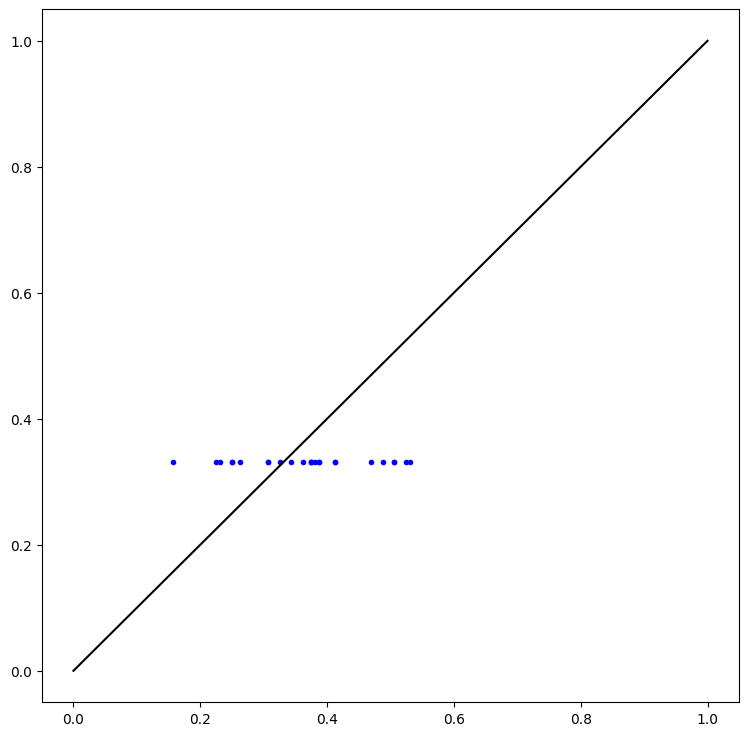

In [29]:
import matplotlib
#Import r2_score
from sklearn.metrics import r2_score

# Get into evaluation (predictive posterior) mode
embedding_regressor.eval()
likelihood.eval()

if isinstance(X_train, np.ndarray):
    X_train = torch.from_numpy(X_train).float()
if isinstance(X_val, np.ndarray):
    X_val = torch.from_numpy(X_val).float()

probe_dim_idx = 2
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(embedding_regressor(X_val.to(device)))

with torch.no_grad():
    # Initialize plot
    #f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    #lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    #ax.plot(X_train[:, probe_dim_idx].numpy(), y_train.numpy(), 'k*')
    # Plot predictive means as blue line
    #ax.plot(X_val[:, probe_dim_idx].cpu().numpy(), observed_pred.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    #ax.fill_between(X_val[:, probe_dim_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
    #ax.set_ylim([-3, 3])
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    np_observed_pred = observed_pred.mean.cpu().numpy()
    rmse = np.sqrt(np.mean((np_observed_pred - y_val)**2))
    r2 = r2_score(y_val, np_observed_pred)
    print('RMSE: ', rmse)
    print('r2: ', r2)
    

    f, ax = matplotlib.pyplot.subplots(1, 1, figsize=(9, 9))
    
    #observed_pred = torch.mean(observed_pred.mean, dim=0)

    ax.plot(y_val, observed_pred.mean.cpu().numpy(), 'b.')
    ax.plot([0, 1], [0, 1], 'k-')

    #ax.fill_between(X_val[:, probe_dim_idx].cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)




In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
os.environ["TORCH_DISTRIBUTED_DEBUG"]="DETAIL"

os.environ["WANDB_API_KEY."]="925f0f3c8de42f022a0a5a390aab9845cb5c92cf"
#wandb.login()
# WandB – Initialize a new run
wandb.init(project="article_mean_score_regression")
# save the trained model checkpoint to wandb
#os.environ["WANDB_LOG_MODEL"]="true"
# turn off watch to log faster
os.environ["WANDB_WATCH"]="all"

training_args = TrainingArguments(output_dir=model_output_dir,
                                        #report_to="wandb",
                                        #logging_steps=5,
                                        #run_name="...", # A descriptor for the run. Typically used for wandb logging.
                                        label_names= ["targets"],
                                        remove_unused_columns=False,
                                        per_device_train_batch_size=32,
                                        per_device_eval_batch_size=8,
                                        #dataloader_drop_last=True, 
                                        #gradient_accumulation_steps=2,
                                        #gradient_checkpointing=True,
                                        #fp16=True,#,tf32=True,
                                        optim="adamw_torch",
                                        learning_rate=0.002,
                                        num_train_epochs=4000,
                                        #max_steps = 25,
                                        save_strategy="epoch",
                                        save_steps = 2,
                                        #do_eval=True,
                                        evaluation_strategy="epoch", 
                                        #eval_steps=20, #10,
                                        seed=global_seed,
                                        dataloader_pin_memory=False,
                                        deepspeed=None,
                                        )
    
# Store some key paramters to the WandB config for later reference
config = wandb.config          # Initialize config

config.TRAIN_BATCH_SIZE = training_args.per_device_train_batch_size  
config.VALID_BATCH_SIZE = training_args.per_device_eval_batch_size   
config.TRAIN_EPOCHS = training_args.num_train_epochs           
#config.VAL_EPOCHS = training_args.num_eval_epochs      
config.LEARNING_RATE = training_args.learning_rate    
config.SEED = training_args.seed

variational_learning_rate = 0.1
use_NGD = True
use_trainer_class = False

############################################################################
############################################################################
############################################################################

num_inducing_points = len(y_train) #Initialiye with 200 random points from the training set
inducing_points = []
for idx in range(num_inducing_points):
    inducing_points.append(X_train[idx, :])
    
inducing_points = torch.concatenate([ind_point.reshape(1, -1) for ind_point in inducing_points], axis=0)
inducing_points = inducing_points

likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.BetaLikelihood()
likelihood_label = "GaussianLikelihood" if isinstance(likelihood, gpytorch.likelihoods.GaussianLikelihood) else "BetaLikelihood"
likelihood.to(device)


if use_NGD:
    variational_dist_label = "NaturalVariationalDistribution"
    #variational_dist_label = "TrilNaturalVariationalDistribution"
    embedding_regressor = CustomVariationalGPModelWithNGD(inducing_points=inducing_points, likelihood_label=likelihood_label, variational_dist_label=variational_dist_label)
    embedding_regressor.to(device)

    variational_ngd_optimizer = gpytorch.optim.NGD(embedding_regressor.variational_parameters(), 
                                                   num_data=len(train_data), 
                                                   lr=variational_learning_rate)

else:
    embedding_regressor = CustomVariationalGPModel(inducing_points=inducing_points, likelihood_label=likelihood_label)
    embedding_regressor.to(device)

gp_loss = gpytorch.mlls.VariationalELBO(likelihood, embedding_regressor, num_data=len(train_data)) #num_data: Number of 

train_loader = DataLoader(train_data, batch_size=training_args.per_device_train_batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=training_args.per_device_eval_batch_size,shuffle=False)

# Start training

embedding_regressor.train()
likelihood.train()


if not use_trainer_class and use_NGD:
    
    hyperparameter_optimizer = torch.optim.Adam([
        {'params': embedding_regressor.hyperparameters()},
        {'params': likelihood.parameters()},
    ], lr=training_args.learning_rate)

    epochs_iter = tqdm(range(training_args.num_train_epochs), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
        for batch in minibatch_iter:
            ### Perform NGD step to optimize variational parameters
            variational_ngd_optimizer.zero_grad()
            hyperparameter_optimizer.zero_grad()
            output = embedding_regressor(batch["embeddings"].to(device))
            loss = -gp_loss(output, batch["targets"].squeeze(-1).to(device))
            wandb.log({"loss": loss.item()})
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            variational_ngd_optimizer.step()
            hyperparameter_optimizer.step()

if not use_trainer_class and not use_NGD:

    optimizer = torch.optim.AdamW([
        {'params': embedding_regressor.parameters()},
        {'params': likelihood.parameters()},
    ], lr=training_args.learning_rate)

    epochs_iter = tqdm(range(training_args.num_train_epochs), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm(train_loader, desc="Minibatch", leave=False)
        for batch in minibatch_iter:
            optimizer.zero_grad()
            output = embedding_regressor(batch["embeddings"].to(device))
            loss = -gp_loss(output, batch["targets"].squeeze(-1).to(device))
            minibatch_iter.set_postfix(loss=loss.item())
            loss.backward()
            optimizer.step()
            
            

elif use_trainer_class:
    
    trainer = CustomEnd2EndGPRegressionTrainer(model=embedding_regressor,
                                                args=training_args,
                                                loss_func_or_wrapper=gp_loss,
                                                likelihood=likelihood,
                                                device=device,
                                                train_dataset=train_data,
                                                eval_dataset=val_data,
                                                #data_collator=data_collator,
                                                #compute_metrics=compute_metrics,
                                            )

    trainer.train()
            

    

loss,█▇▆▅▅▄▃▂▂▂▃▂▂▄▃▄▂▂▁▁▄▃▇▂▅▄▂▁▃▃▁▂▁▁▂▃▂▁▇▂
loss,-0.98361


Epoch: 100%|██████████| 4000/4000 [05:25<00:00, 12.27it/s]


In [ ]:
c

#### Evaluation

In [35]:

train_preds_df = evaluate_gp_model(embedding_regressor, likelihood, train_loader, "./del.csv", device)
preds_df = evaluate_gp_model(embedding_regressor, likelihood, val_loader, "./gp_preds.csv", device)

y_train_pred = train_preds_df["prediction"].values
y_pred = preds_df["prediction"].values


f_preds:  MultivariateNormal(loc: torch.Size([32]), covariance_matrix: torch.Size([32, 32]))
f Result:  torch.Size([32]) torch.Size([32, 1])
y Result:  torch.Size([32]) torch.Size([32, 1]) tensor([0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187,
        0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187,
        0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187, 0.0187,
        0.0187, 0.0187, 0.0187, 0.0187, 0.0187], device='cuda:0')
Errors:  tensor([[0.0706, 0.0706, 0.0706,  ..., 0.0706, 0.0706, 0.0706],
        [0.0644, 0.0644, 0.0644,  ..., 0.0644, 0.0644, 0.0644],
        [0.1731, 0.1731, 0.1731,  ..., 0.1731, 0.1731, 0.1731],
        ...,
        [0.1394, 0.1394, 0.1394,  ..., 0.1394, 0.1394, 0.1394],
        [0.1981, 0.1981, 0.1981,  ..., 0.1981, 0.1981, 0.1981],
        [0.0356, 0.0356, 0.0356,  ..., 0.0356, 0.0356, 0.0356]],
       device='cuda:0')
Finished computing metrics
Targets:  [[0.375  ]
 [0.36875]
 [0.13125]
 [0.

In [36]:
print(y_pred.shape, y_val.shape)
print(preds_df["variability"].values)

(25,) (25, 1)
[0.01868634 0.01868634 0.01868634 0.01868634 0.01868634 0.01868634
 0.01868634 0.01868634 0.01868634 0.01868634 0.01868634 0.01868634
 0.01868634 0.01868634 0.01868634 0.01868634 0.01868634 0.01868634
 0.01868634 0.01868634 0.01868634 0.01868634 0.01868634 0.01868634
 0.01868634]


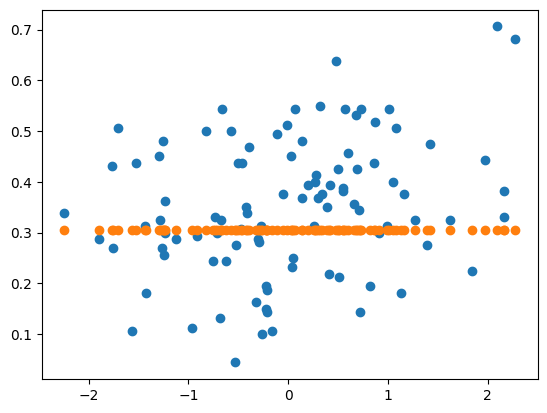

In [37]:
import matplotlib.pyplot as plt

hidden_feat_idx = 5

plt.scatter(X_train[:, hidden_feat_idx], y_train, label="data")
plt.scatter(X_train[:, hidden_feat_idx], y_train_pred, label="prediction")


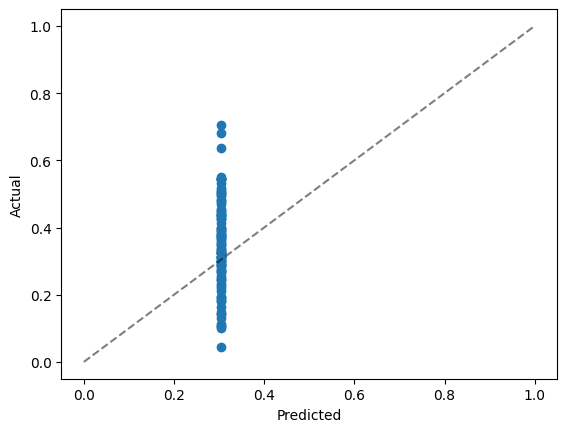

In [38]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("Predicted")
plt.ylabel("Actual")
#Diagonal line is the ideal
#plot!([0, 1], [0, 1], linestyle=:dash, color=:black, alpha=0.5)
plt.plot([0, 1], [0, 1], linestyle='--', color='black', alpha=0.5)
#legend!(false)

Text(0, 0.5, 'Actual')

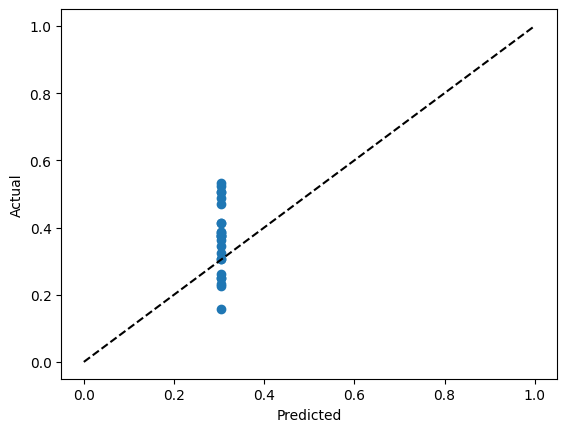

In [39]:

plt.scatter(y_pred, y_val)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted')
plt.ylabel('Actual')